# Starbucks Capstone Challenge

### Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

### Problem Statement
The aim is develop a set of charecterstics to determine which customers complete which offer type. To explore the customers of Starbucks and their behavior regarding the offers they recieve. Also, to check if we can predict what type of offer is the best for each user based on their demographics. This would help in increasing the completion of offers for the customers which means higher sales and profits. If the user recievs relevant offers, they'll most likely respond to it. Which will help the company in focusing their effort and resources in the most requested and interacted offers.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from time import time

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Datasets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
print('The protfolio df has a shape of', portfolio.shape)

The protfolio df has a shape of (10, 6)


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
print('The profile df has a shape of', profile.shape)

The profile df has a shape of (17000, 5)


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
print('The transcript df has a shape of', transcript.shape)

The transcript df has a shape of (306534, 4)


# Data Wrangling/Preprocessing

## portfolio

### Channel one-hot encoding
Let's express the channels of the offer in 0s and 1s.

In [9]:
channel_types = set()
for i in portfolio.channels:
    channel_types.update(set(i))
channel_types

for i in channel_types:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

In [10]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,web,mobile,email,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


In [11]:
portfolio = portfolio.drop('channels', axis=1)

### Null values
Check if the df has any NaN values and deal with them.

In [12]:
portfolio.isnull().sum(axis=0) * 100 / portfolio.shape[0]

difficulty    0.0
duration      0.0
id            0.0
offer_type    0.0
reward        0.0
web           0.0
mobile        0.0
email         0.0
social        0.0
dtype: float64

There is no NaN values in this df.

### Change the "id" column to "offer_id"
This is so when I decide to join all the df into a one df, the columns will not get mixed up.

In [13]:
portfolio = portfolio.rename(columns = {"id":"offer_id"})
portfolio.sample(5)

,difficulty,duration,offer_id,offer_type,reward,web,mobile,email,social
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1


### Change the "reward" column to "offer_reward"
This is so when I decide to join all the df into a one df, the columns will not get mixed up.

In [14]:
portfolio = portfolio.rename(columns = {"reward":"offer_reward"})
portfolio.sample(5)

,difficulty,duration,offer_id,offer_type,offer_reward,web,mobile,email,social
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


## profile


In [15]:
profile.sample(10)

,age,became_member_on,gender,id,income
15259,52,20150822,M,2cfc6a4a5fe643f4b3fe7635cd5af6dd,54000.0
754,46,20151229,F,5508e87b5a874f5fb73492a7e3e25309,36000.0
11639,23,20180304,F,725faa874f884a12997de861d5afc09b,43000.0
10225,51,20151031,M,a29f77fbfa8b4412966080028a5beb30,47000.0
2018,36,20170918,M,b89526113c2a4313a6d0ec0522a77e7b,41000.0
2463,118,20170731,None,331f88bc7b5042ec9a4c90bb8e516cb5,NaN
5584,22,20151208,M,2c92470dae4648e6aa187fc5bf7668e8,46000.0
960,63,20171005,M,6da230f857a54b8da221aa05f9e652af,58000.0
15016,72,20180120,M,a42d922636524c8c93b20b5c1be1d933,68000.0
5000,67,20171224,F,4ddaa5065f754bf19f90a87af8f448f5,85000.0


### Null values
#### Gender and income
Check if the df has NaN values.

In [16]:
profile.isnull().sum(axis=0)*100/profile.shape[0]

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

In [17]:
gender_counts = profile['gender'].value_counts()
gender_counts = gender_counts*100/gender_counts.sum(axis=0)
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

I'll drop the rows where there is no income and no gender specified. This include the 'O' label too.

In [18]:
profile = profile[profile['income'].notnull()]
profile = profile[profile['gender'] != 'O']
profile = profile.reset_index(drop=True)

In [19]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

age                 0.0
became_member_on    0.0
gender              0.0
id                  0.0
income              0.0
dtype: float64

Check how many profiles left:

In [20]:
print('The profile df has a shape of', profile.shape)

The profile df has a shape of (14613, 5)


## Mapping the Gender values
Mapping the gender from strings to 0 and 1 to make it easier in processing later.

In [21]:
profile['gender'] = profile['gender'].map({'M': 0,'F': 1})
profile.sample(5)

,age,became_member_on,gender,id,income
5853,42,20180724,0,03fe8e9f855846c88fd01c4b7b147db7,53000.0
3760,53,20180125,1,227f56602add4665a5c3633f08a08656,105000.0
7133,33,20170728,1,26275bfb01394582b7b5e49f9d0b7d27,40000.0
4987,67,20180113,0,c738ad104ecb455bb035e4ae9ecfd8f4,39000.0
5008,77,20161220,0,7308c738e39b4e4e9b6beec61ef4cf3c,72000.0


## Converting the 'became_member_on' column to a datetime object
This to easly extract the date values in the exploration later on.

In [22]:
profile['became_member_on'] =  pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.sample(5)

# From: https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime

,age,became_member_on,gender,id,income
11686,50,2017-08-05,1,b5089461bd1a427c8874d5e36d3a2d40,50000.0
10559,55,2018-02-25,1,7fd1bdfdb0a9430c919ba908dddf0254,75000.0
3051,61,2017-11-09,1,e8630f5d3bf34260be5241a633f0fa42,65000.0
1445,39,2017-12-21,0,2eb1f939e4e44b11b753af7c44aa6f7f,37000.0
5609,59,2018-02-07,1,5a5657e28a384f17a4cfae36852e2abe,79000.0


In [23]:
profile['memb_start_year'] = profile['became_member_on'].apply(lambda elem: elem.year)
profile['memb_start_month'] = profile['became_member_on'].apply(lambda elem: elem.month)
profile['memb_start_day'] = profile['became_member_on'].apply(lambda elem: elem.day)

### Change the "id" column to "customer_id"
This is so when I decide to join all the df into a one df, the columns will not get mixed up.

In [24]:
profile = profile.rename(columns = {"id":"customer_id"})
profile.sample(5)

,age,became_member_on,gender,customer_id,income,memb_start_year,memb_start_month,memb_start_day
3759,52,2018-04-17,1,8bde85edb35d4fa89c69631204b3da1d,67000.0,2018,4,17
6025,70,2015-07-28,0,7a96cdb7ae6047f7ad042e8f97e66ae0,34000.0,2015,7,28
6099,36,2014-01-22,0,f70e4e136db845fc8d9999a5c5941478,40000.0,2014,1,22
6122,73,2016-01-15,1,b3533603c9e545cc96949e1f7e195eb9,109000.0,2016,1,15
3793,61,2018-02-02,0,9f9aedfb14614efeb837506465b293c0,106000.0,2018,2,2


## transcript

In [25]:
transcript.sample(5)

,event,person,time,value
26089,offer viewed,a9996f30c54d47d695bf54afbf7bcb4c,30,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
6826,offer received,e754520250894679afdc4697d60938c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
112602,offer received,7c8a7b0fc3724280a05585cec13c8a23,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
198514,transaction,5cd3b3a0e5284df1adf8cca2f59ed28f,492,{'amount': 1.76}
28356,transaction,bcd9fbbb25454c38be9ed35ca901896e,42,{'amount': 3.89}


### Null values
Check if the df has NaN values.

In [26]:
transcript.isnull().sum(axis=0)*100/transcript.shape[0]

event     0.0
person    0.0
time      0.0
value     0.0
dtype: float64

### The value column engineering
The value column consist of a dictionary of different information. It can be converted to another columns that contain the information. First let's see what types of dictionary are there.

In [27]:
dic_types = []
for index, event in transcript.iterrows():
    for item in event['value']:
        if item in dic_types:
            continue
        else:
            dic_types.append(item)

dic_types

# From: https://stackoverflow.com/questions/56187195/iterate-through-rows-in-a-dataframe-and-change-value-of-a-column-based-on-other

['offer id', 'amount', 'offer_id', 'reward']

There are three types of information (the offer id is recorded in different ways), I'll split them to multiple columns and drop the value column.

In [28]:
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for index, event in transcript.iterrows():
    for item in event['value']:
        if item == 'offer id':
            transcript.at[index, 'offer_id']= event['value'][item]
        if item == 'offer_id':
            transcript.at[index, 'offer_id']= event['value'][item]
        if item == 'amount':
            transcript.at[index, 'amount']= event['value'][item]
        if item == 'reward':
            transcript.at[index, 'reward']= event['value'][item]
            
# From: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

In [29]:
transcript = transcript.drop('value', axis=1)
transcript.sample(10)

,event,person,time,offer_id,amount,reward
66759,transaction,73f25ac9f11a4a95b37e247fe7a5f553,168,,10,0
84541,transaction,bdf1c179bfe648408b5a4ffa074ec5f6,210,,12,0
74437,offer viewed,cfefa4c2c2aa40a196f392e43eb5eeed,180,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
64264,offer received,b2daf4ff73cc4791b6ae6d9c41223b69,168,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
283943,transaction,d1c4500ace2e45e9a45d3cd2fccac8d8,624,,7,0
106145,transaction,233c4cb4bd5b48e1bf461e4e7774d5c7,306,,33,0
52121,transaction,6b040d1c99e84530ac93693ef5714da6,156,,2,0
42257,transaction,8f0d8c7a45924f688c140dd9fe4db0b4,102,,4,0
91542,transaction,5fd5740cc7c7433caa24e38316277557,234,,21,0
17457,transaction,2091c0756edc4046a3cd3032522f6657,6,,18,0


### Cross check if each customer is the profile df
First I'll change the column name to match the profile name. Then I'll check if each transaction/event is in the profile df. This is to know if the demographic data is available for each event.

In [30]:
transcript = transcript.rename(columns = {"person":"customer_id"})

In [31]:
common_customers = transcript['customer_id'].isin(profile['customer_id'])
print('The number of events for all customers: ', transcript.shape[0])
print('The number of events for only the customers in the profile df: ', common_customers.sum())

The number of events for all customers:  306534
The number of events for only the customers in the profile df:  268791


So, about 40K of the customers we don't have their demographic data. I'll drop these rows since they will not contribute to the model later.

In [32]:
transcript = transcript[common_customers]

In [33]:
print('The number of remaining events ', transcript.shape[0])

The number of remaining events  268791


### Convert the time to days
For the sake of making all the units unified, I'll convert the hours to days. I'm not sure if I'll use this column in the analysis or the model later.

In [34]:
transcript['time'] = transcript['time'] / 24
transcript.sample(10)

,event,customer_id,time,offer_id,amount,reward
297726,transaction,ba8457f994234f27bb0703e60518ba26,28.00,,4,0
243797,offer completed,06131d1c0a154320bd9b24af9f51f76d,23.75,2298d6c36e964ae4a3e7e9706d1fb8c2,0,3
231388,transaction,703e3ddbbb824a3f9cfd737dcc479743,22.25,,34,0
271768,offer viewed,379ef2e7156d4e339bc81b29e38548f6,24.75,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
305585,transaction,09218129551d4929a3beea8d3eafd787,29.75,,17,0
10141,offer received,eb1bcbe31d694083bdb22de0a8a91d87,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,0
43836,transaction,4d7b50337cdb4ccfb7d13474ababdcc0,4.50,,13,0
94953,offer viewed,260e79fc9c0e4c9aad32752767e9d74d,10.25,2906b810c7d4411798c6938adc9daaa5,0,0
197830,transaction,00bc42a62f884b41a13cc595856cf7c3,20.25,,14,0
69410,offer viewed,17e445a1d599462983560919c20009df,7.25,f19421c1d4aa40978ebb69ca19b0e20d,0,0


In [35]:
transcript['time'] = np.ceil(transcript['time'])
transcript.sample(10)

,event,customer_id,time,offer_id,amount,reward
81646,transaction,e4ea64fc15d24fd39819c190d90569a3,9.0,,8,0
297262,transaction,d8a7d08af02243ae8ba4206010bb57f9,28.0,,3,0
107158,transaction,996fb8e62375461f8f6ca0cf7d2eeaa3,13.0,,5,0
206595,offer received,b8e5c831475c42158d68dda130ea93c7,21.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
50888,transaction,ab36b436924042459401a8e140795a7e,7.0,,21,0
212742,offer received,64f2b7a9b500432bb6977afd6b88e54d,21.0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
250367,offer received,2d7d36f30d094fdbba602b64e7f69d60,24.0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
186462,offer completed,aecc4f164b69498fa32aa173636fecbe,19.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10
301132,transaction,f91bfc9355c045258102072672118367,29.0,,10,0
142101,offer completed,680fc72906a1408abdb350adc8c35667,16.0,fafdcd668e3743c1bb461111dcafc2a4,0,2


### Change the "reward" column to "transcript_reward"
This is so when I decide to join all the df into a one df, the columns will not get mixed up.

In [36]:
transcript = transcript.rename(columns = {"reward":"transcript_reward"})
transcript.sample(5)

,event,customer_id,time,offer_id,amount,transcript_reward
82861,offer completed,fe54dec74c99440bb4ee266e2a4c778d,9.0,2906b810c7d4411798c6938adc9daaa5,0,2
268601,transaction,51d6dce2d36b4185a13d0ae5bff178c6,25.0,,9,0
303133,transaction,0fef5deff281421ea470b939ffce1e30,29.0,,19,0
28274,transaction,69e6c4ed12ca4b6194317ece94122792,2.0,,1,0
21727,offer viewed,eb3ce155c32f4c80a29a3417a1e698d5,1.0,2906b810c7d4411798c6938adc9daaa5,0,0


# EDA
In this section, I'll try to explore the data to understand it more before developing the model.
## Users profiles analysis

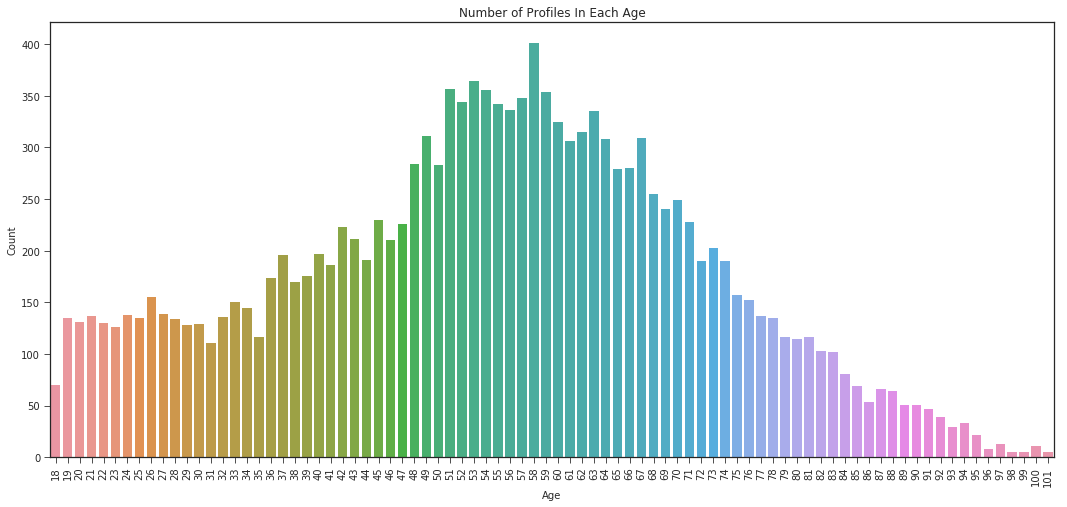

In [37]:
sns.set_style("ticks")
plt.figure(figsize=(18, 8))
g = sns.countplot(profile['age']);
plt.title('Number of Profiles In Each Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

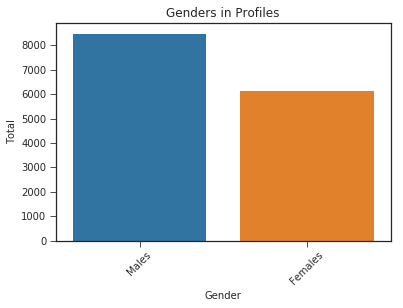

In [38]:
sns.set_style("ticks")
g = sns.countplot(profile['gender'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 45)
g.set_xticks(range(2))
g.set_xticklabels(['Males','Females'])
plt.show();

(array([      0.,   20000.,   40000.,   60000.,   80000.,  100000.,
         120000.,  140000.]), <a list of 8 Text xticklabel objects>)

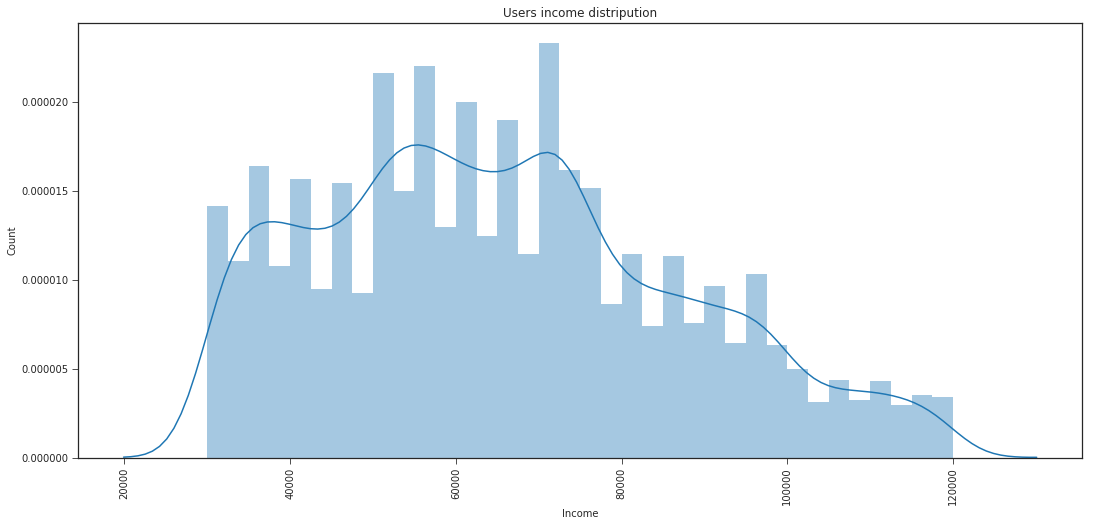

In [39]:
sns.set_style("ticks")
plt.figure(figsize=(18, 8))
g = sns.distplot(profile['income']);
plt.title('Users income distripution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=90)


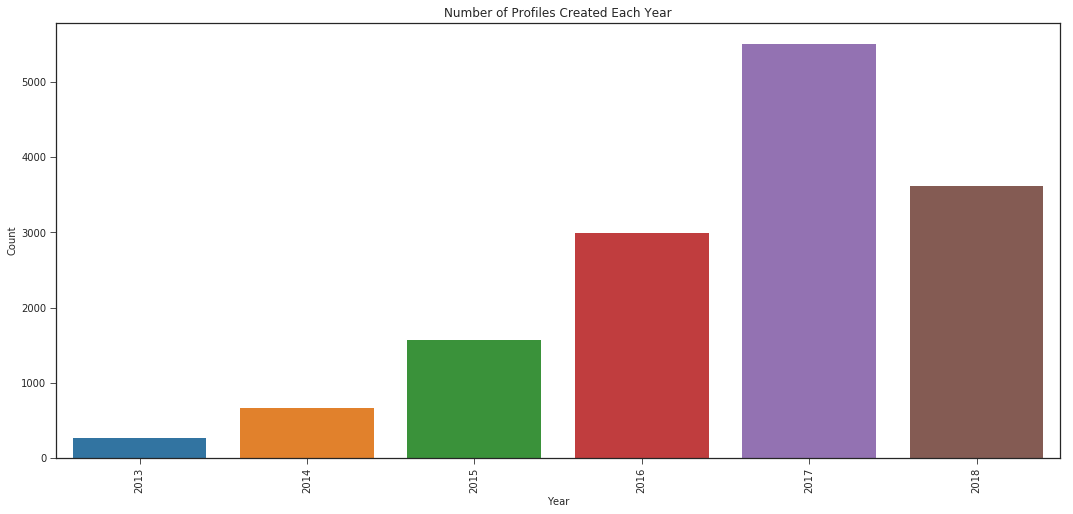

In [40]:
sns.set_style("ticks")
plt.figure(figsize=(18, 8))
g = sns.countplot(profile['memb_start_year']);
plt.title('Number of Profiles Created Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

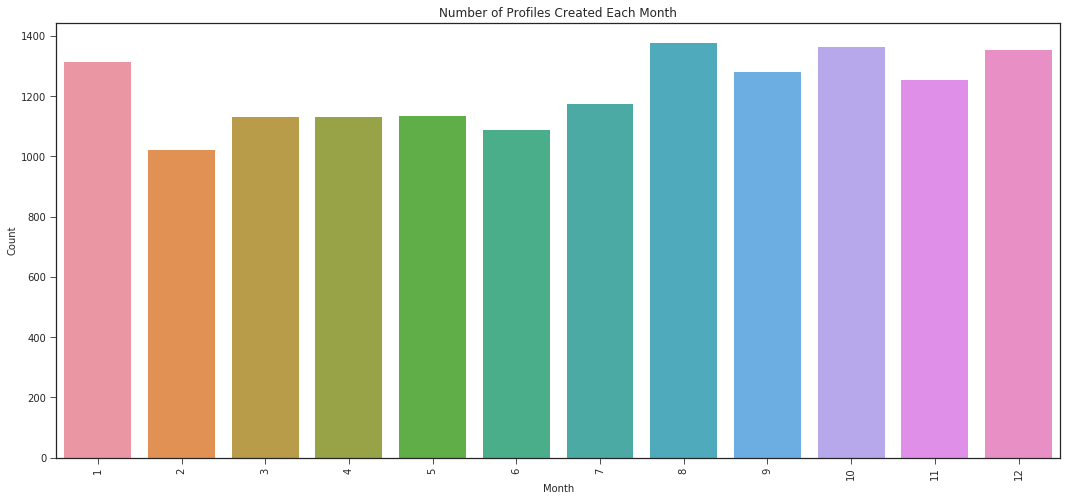

In [41]:
sns.set_style("ticks")
plt.figure(figsize=(18, 8))
g = sns.countplot(profile['memb_start_month']);
plt.title('Number of Profiles Created Each Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Offers analysis

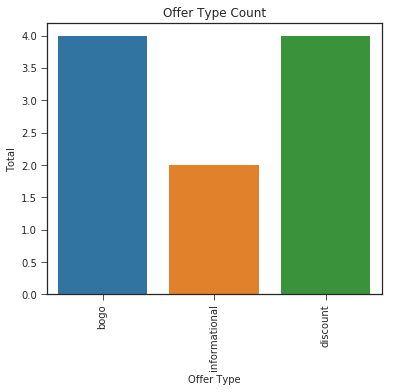

In [42]:
plt.figure(figsize=(6, 5))
g = sns.countplot(portfolio.offer_type)
plt.title('Offer Type Count')
plt.ylabel('Total')
plt.xlabel('Offer Type')
plt.xticks(rotation=90)
plt.show();

To perform deeper analysis, all the dfs were merged into one big df.

In [43]:
transcript_profile = pd.merge(transcript, profile, on='customer_id', how="left")
merged_df = pd.merge(transcript_profile, portfolio, on='offer_id', how='left')
merged_df

,event,customer_id,time,offer_id,amount,transcript_reward,age,became_member_on,gender,income,...,memb_start_month,memb_start_day,difficulty,duration,offer_type,offer_reward,web,mobile,email,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,75,2017-05-09,1,100000.0,...,5,9,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,0,68,2018-04-26,0,70000.0,...,4,26,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,65,2018-02-09,0,53000.0,...,2,9,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,0,58,2017-11-11,0,51000.0,...,11,11,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,61,2017-09-11,1,57000.0,...,9,11,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
5,offer received,31dda685af34476cad5bc968bdb01c53,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,62,2016-02-11,1,71000.0,...,2,11,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
6,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,0,64,2017-09-09,0,100000.0,...,9,9,10.0,7.0,bogo,10.0,0.0,1.0,1.0,1.0
7,offer received,c27e0d6ab72c455a8bb66d980963de60,0.0,3f207df678b143eea3cee63160fa8bed,0,0,78,2017-06-16,1,71000.0,...,6,16,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0
8,offer received,d53717f5400c4e84affdaeda9dd926b3,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,88,2017-05-18,1,53000.0,...,5,18,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
9,offer received,f806632c011441378d4646567f357a21,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,0,42,2013-08-11,0,69000.0,...,8,11,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0


In [44]:
merged_df.columns

Index(['event', 'customer_id', 'time', 'offer_id', 'amount',
       'transcript_reward', 'age', 'became_member_on', 'gender', 'income',
       'memb_start_year', 'memb_start_month', 'memb_start_day', 'difficulty',
       'duration', 'offer_type', 'offer_reward', 'web', 'mobile', 'email',
       'social'],
      dtype='object')

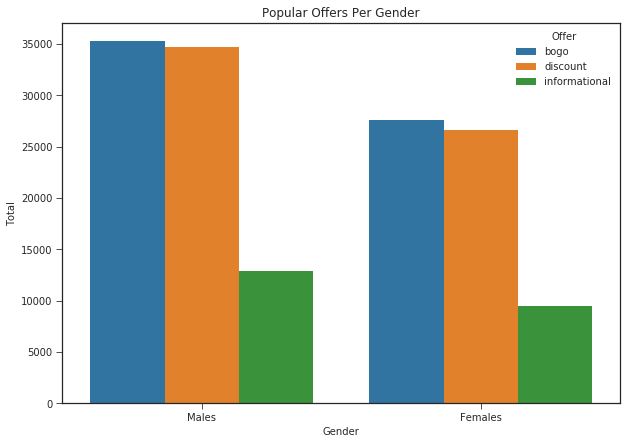

In [45]:
plt.figure(figsize=(10, 7))
g = sns.countplot(x=merged_df.gender, hue=merged_df.offer_type)
plt.title('Popular Offers Per Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
g.set_xticks(range(2))
g.set_xticklabels(['Males','Females'])
plt.show();

In [46]:
merged_df['age_groups'] = pd.cut(merged_df.age, bins=[18, 35, 64, 120], labels=['Youth', 'Adult', 'Elderly'])
# From: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

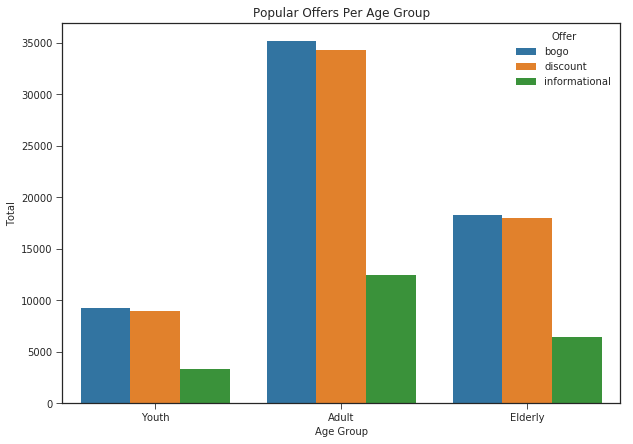

In [47]:
plt.figure(figsize=(10, 7))
g = sns.countplot(x=merged_df.age_groups, hue=merged_df.offer_type)
plt.title('Popular Offers Per Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
#g.set_xticks(range(2))
#g.set_xticklabels(['Males','Females'])
plt.show();

## Transcript analysis

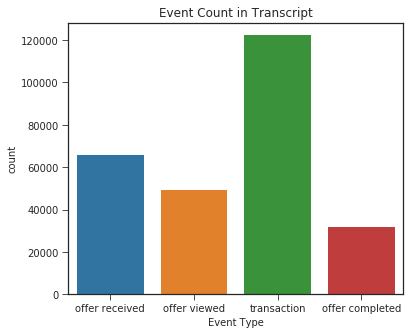

In [48]:
plt.figure(figsize=(6, 5))
g = sns.countplot(transcript['event'])
plt.title('Event Count in Transcript')
plt.ylabel('count')
plt.xlabel('Event Type')
plt.xticks(rotation=0)
plt.show();

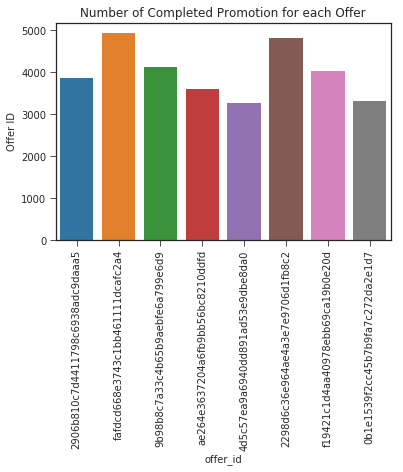

In [49]:
completed_off_count = transcript[transcript['event'] == 'offer completed']
sns.countplot(completed_off_count['offer_id'])
plt.title('Number of Completed Promotion for each Offer')
plt.ylabel('Count')
plt.ylabel('Offer ID')
plt.xticks(rotation = 90)
plt.show();

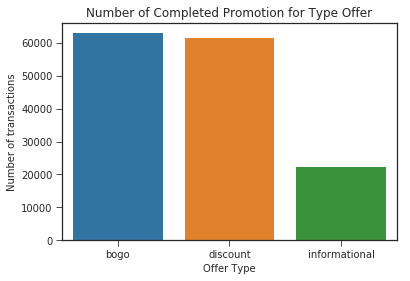

In [50]:
g = sns.countplot(merged_df[merged_df['offer_type'] != '']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 0)
plt.show();

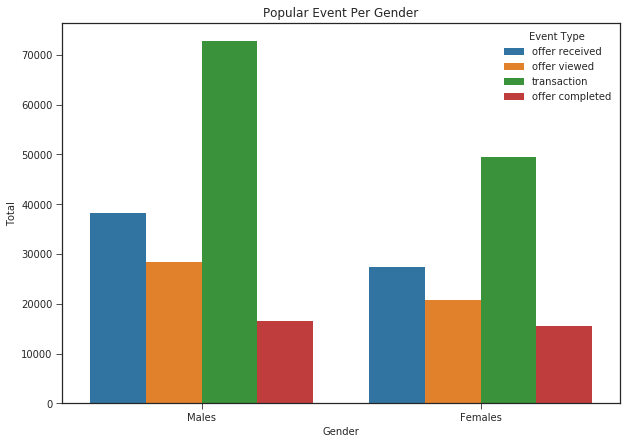

In [51]:
plt.figure(figsize=(10, 7))
g = sns.countplot(x=merged_df.gender, hue=merged_df.event)
plt.title('Popular Event Per Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Event Type')
g.set_xticks(range(2))
g.set_xticklabels(['Males','Females'])
plt.show();

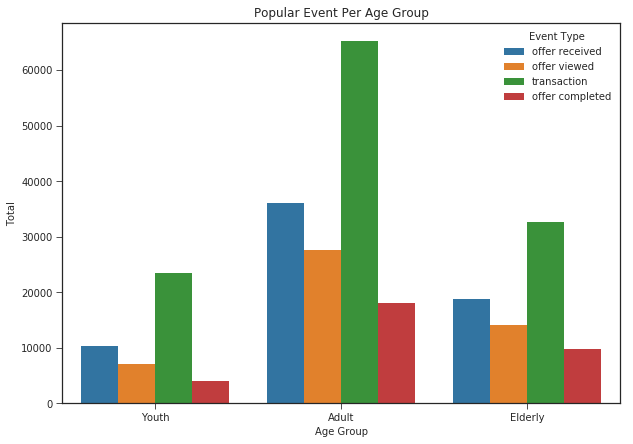

In [52]:
plt.figure(figsize=(10, 7))
g = sns.countplot(x=merged_df.age_groups, hue=merged_df.event)
plt.title('Popular Event Per Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Event Type')
#g.set_xticks(range(2))
#g.set_xticklabels(['Males','Females'])
plt.show();

# Modeling

I'll start by selecting the features and the target needed for the model.


In [53]:
merged_df.columns

Index(['event', 'customer_id', 'time', 'offer_id', 'amount',
       'transcript_reward', 'age', 'became_member_on', 'gender', 'income',
       'memb_start_year', 'memb_start_month', 'memb_start_day', 'difficulty',
       'duration', 'offer_type', 'offer_reward', 'web', 'mobile', 'email',
       'social', 'age_groups'],
      dtype='object')

In [54]:
merged_df.dtypes

event                        object
customer_id                  object
time                        float64
offer_id                     object
amount                        int64
transcript_reward             int64
age                           int64
became_member_on     datetime64[ns]
gender                        int64
income                      float64
memb_start_year               int64
memb_start_month              int64
memb_start_day                int64
difficulty                  float64
duration                    float64
offer_type                   object
offer_reward                float64
web                         float64
mobile                      float64
email                       float64
social                      float64
age_groups                 category
dtype: object

The features will be:
* 'event'
* 'time'
* 'amount'
* 'transcript_reward'
* 'age'
* 'gender'
* 'income'
* 'difficulty'
* 'duration'
* 'offer_reward'
* 'social'
* 'email'
* 'web',
* 'mobile'

And the target would be:
* 'offer_type'

The features will need further processing before they are ready for the model training. I decided to drop all the rows where there are no offer type, since they will not help in the prediction. I only have rows as the same number of users we have.

In [55]:
merged_df = merged_df[merged_df['offer_type'].notnull()]
merged_df = merged_df.reset_index(drop=True)

In [56]:
X = merged_df[['event', 'time', 'amount','transcript_reward', 'age', 'gender', 'income',
               'difficulty', 'duration', 'offer_reward', 'social', 'email', 'web', 'mobile']]
Y = merged_df[['offer_type']]

Now, I'll change the 'event' and 'offer_type' from categorical to numerical values.

In [57]:
X['event'].astype('category').cat.categories.tolist()

['offer completed', 'offer received', 'offer viewed']

In [58]:
X['event'] = X['event'].map({'offer completed': 1,'offer received': 2, 'offer viewed': 3,'transaction': 4})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
Y['offer_type'].astype('category').cat.categories.tolist()

['bogo', 'discount', 'informational']

In [60]:
Y['offer_type'] = Y['offer_type'].map({'bogo': 1,'discount': 2, 'informational': 3})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
X.sample(10)

,event,time,amount,transcript_reward,age,gender,income,difficulty,duration,offer_reward,social,email,web,mobile
88267,3,18.0,0,0,55,0,37000.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0
26131,2,7.0,0,0,21,0,58000.0,5.0,7.0,5.0,0.0,1.0,1.0,1.0
80968,2,17.0,0,0,70,1,81000.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0
44039,3,9.0,0,0,30,1,37000.0,10.0,5.0,10.0,1.0,1.0,1.0,1.0
108574,1,21.0,0,5,60,1,90000.0,5.0,7.0,5.0,0.0,1.0,1.0,1.0
35323,3,7.0,0,0,49,0,68000.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0
141862,1,26.0,0,5,68,1,42000.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0
107256,3,21.0,0,0,55,1,75000.0,10.0,7.0,2.0,0.0,1.0,1.0,1.0
69923,1,17.0,0,3,46,1,43000.0,7.0,7.0,3.0,1.0,1.0,1.0,1.0
119903,2,24.0,0,0,65,1,57000.0,5.0,7.0,5.0,0.0,1.0,1.0,1.0


Here, I'll normalize the following columns to get better results in the models.

In [62]:
scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'transcript_reward', 'age', 'income', 'difficulty', 'duration', 'offer_reward']

X[to_normalize] = scaler.fit_transform(X[to_normalize])
X.sample(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,event,time,amount,transcript_reward,age,gender,income,difficulty,duration,offer_reward,social,email,web,mobile
126860,2,0.800000,0.0,0.0,0.506024,0,0.266667,0.25,0.571429,0.5,0.0,1.0,1.0,1.0
26040,2,0.233333,0.0,0.0,0.361446,1,0.455556,0.25,0.285714,0.5,1.0,1.0,1.0,1.0
69311,1,0.566667,0.0,0.5,0.746988,0,0.644444,1.00,1.000000,0.5,0.0,1.0,1.0,0.0
79819,2,0.566667,0.0,0.0,0.385542,1,0.033333,0.00,0.000000,0.0,1.0,1.0,0.0,1.0
43437,3,0.300000,0.0,0.0,0.313253,0,0.411111,0.00,0.142857,0.0,0.0,1.0,1.0,1.0


Splitting the data into training and test data set

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

## Metrics
For the metrics used in this project, I'll use the accuracy. It will provide a good insight on wiether the model is doing well by computing the number of correctly predicted target over the total number of predictions.

## Model selection
I'll compare 3 different models to see which one performs the best for this problem:
1. Logistic Regressuin.
2. Desicion Tree Classifier.
3. SVM.

In [64]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    learner.fit(X_train, y_train)
    
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the training set(X_train) using .predict()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
            
    # Compute accuracy on the training set
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Success
    print("Accuracy of {} classifier on training set:{}.".format(learner.__class__.__name__, results['acc_train']))
    print("Accuracy of {} classifier on test set:{}.".format(learner.__class__.__name__, results['acc_test']))
    # Return the results
    
    return results

# From the first project in this nano degree

In [65]:
clf_LG = LogisticRegression(random_state=0)
clf_DT = DecisionTreeClassifier(random_state=0)
clf_SVC = SVC(random_state=0)

In [66]:
results = {}
for clf in [clf_LG, clf_DT, clf_SVC]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of LogisticRegression classifier on training set:1.0.
Accuracy of LogisticRegression classifier on test set:1.0.
Accuracy of DecisionTreeClassifier classifier on training set:1.0.
Accuracy of DecisionTreeClassifier classifier on test set:1.0.
Accuracy of SVC classifier on training set:1.0.
Accuracy of SVC classifier on test set:1.0.


## Comments and improvements
The classification models are achieving 100% accuracy, which means that they are overfitted to the data in hand. This is for couple of reasons:
* The number of data used in this fitting is not enough (after the drop of 45% of the merged_df).
* The models does not represent the behavior of the data - But since some of them already are simple models, they are not too complex for the issue.

Also, the transcript dataset has a an event called transactions. And since my problem is about predicting the best offer type for each user, I couldn't use this event which apears to be the most available event in the df (based of the EDA above).

Another issue I suspect is in the merging of the dfs. I don't belive that the method I used is the best one, it barely merged the dfs on the common key. A better way to do it is by iterating through the transcript df and using the customer id to lookup the customer demographic data to add them to each transcript. Then using the offer id do the same process to get the offer info from the portfolio df. Due to the limited time, I was not able to do this. Also, it will take a lot of time to go through the huge number of rows.

# Conclusion

In this project, my aim was to explore the customers of Starbucks and their behavior regarding the offers they recieve. Also, to check if we can predict what type of offer is the best for each user based on their demographics. The findings of the analysis can be found in this [post](). I comapred three classifiers to determine what is the best one to predict the best offer type for a customer: Logistic Regressuin , Desicion Tree Classifier, SVM. At the end, I was not able to select one of these models as they all apear to overfit the data.